In [3]:
%matplotlib inline
%load_ext autoreload
%autoreload 2


import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from joblib import Parallel, delayed
import seaborn as sns
sns.set_style('white')
sns.set_context('notebook', font_scale=1.3)

from agents import Agent
from mouselab import MouselabEnv
from distributions import Normal, Categorical
from policies import FixedPlanPolicy
from evaluation import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Define environments

In [4]:
def make_env(cost, ground_truth=False, initial_states=None):
    """Returns a MouselabEnv with branching [4,1,2].
    
    If `ground_truth` is True, the reward observed at a given node will be
    constant across runs on this env. This reduces variance of the return."""
    reward = Normal(0, 10).to_discrete(6)
    env = MouselabEnv([4,1,2], reward=reward, cost=cost, initial_states=initial_states)
    if ground_truth:
        env.ground_truth = np.array([0, *reward.sample(len(env.tree) - 1)])
    return env

def make_envs(cost, n=100, ground_truth=None, initial_states=None):
    # Note, ground_truth can be an int in which case it acts as a random seed.
    if ground_truth is not None:
        np.random.seed(ground_truth)
        return [make_env(cost, True, initial_states) for _ in range(n)]
    else:
        return [make_env(cost, False, initial_states)] * n

We train the LC policy on environments with random reward structures.
However, to ensure that the policy is near-optimal on belief states
that participants find themselves in, the initial state is drawn from
the empirical belief-state distribution of human participants in the
no-feedback condition.

In [5]:
import json
def read_state_actions():
    with open('data/state_actions.json') as f:
        data = json.load(f)
    result = {}
    for cost in data:
        result[float(cost)] = r = {}
        env = make_env(float(cost))
        def parse_state(state):
            return tuple(env.reward if x == '__' else float(x)
                  for x in state)
        def parse_action(action):
            return env.term_action if action == '__TERM_ACTION__' else action
        r['states'] = list(map(parse_state, data[cost]['states']))
        r['actions'] = list(map(parse_action, data[cost]['actions']))
    return result

state_actions = read_state_actions()

# Train LC policy

In [9]:
import skopt
import warnings
from evaluation import *
warnings.filterwarnings("ignore", 
                        message="The objective has been evaluated at this point before.")

COSTS = state_actions.keys()
N_TRAIN = 500
N_CROSS_VAL = 2000
N_CALLS = 40
NORMALIZE = True

def filename(cost):
    c = round(float(cost), 5)
    return 'data/421_{}'.format(c)
    
        
def write_bo_policy(cost):
    empirical_states = state_actions[cost]['states']
    train_envs = make_envs(cost, initial_states=empirical_states, n=N_TRAIN)
    pol, result = bo_policy(train_envs, max_cost=len(train_envs[0].tree),
                            normalize_voi=True, n_random_starts=10,
                            n_calls=N_CALLS, n_jobs=25, return_result=True,)
    fn = filename(cost)
    result.specs['args'].pop('func')  # can't pickle
    result.specs['info'] = {
        'cost': cost,
        'n_train': N_TRAIN,
        'n_calls': N_CALLS,
        'theta': pol.theta
    }
    skopt.dump(result, fn + '.pkl')
    np.save(fn + '.npy', pol.theta)
    return result

def read_bo_policy(cost, cross_val=True):
    result = read_bo_result(cost)
    empirical_states = state_actions[cost]['states']
    envs = make_envs(cost, initial_states=empirical_states, n=N_CROSS_VAL)
    if cross_val:
        n_consider = 5
        idx = result.func_vals.argsort()[:n_consider]
        top_x = np.array(result.x_iters)[idx]
        top_theta = [x2theta(x, True) for x in top_x]
        theta = max(top_theta, key=
                    lambda th: get_util(LiederPolicy(th), envs, parallel=Parallel(20)))
    else:
        return LiederPolicy(result.specs['info']['theta'])
    return LiederPolicy(theta)

def read_bo_result(cost):
    return skopt.load(filename(cost) + '.pkl')

import joblib
cv_file = 'data/cross_val_policies.pkl'
try:
    policies = joblib.load(cv_file)
    print('Loaded', cv_file)
except FileNotFoundError:
    print('Training LC policies')
    for c in COSTS:
        write_bo_policy(c)
    policies = {c: read_bo_policy(c, cross_val=True) for c in COSTS}
    print('Running cross validation')
    joblib.dump(policies, cv_file)

Loaded data/cross_val_policies.pkl


In [5]:
print('Learned feature weights:')
pd.DataFrame(
    [[cost, *pol.theta.round(2)] for cost, pol in policies.items()],
    columns='cost COST VOI_1 VPI_a VPI_full TERM_REWARD'.split()
).set_index('cost')


Learned feature weights:


,COST,VOI_1,VPI_a,VPI_full,TERM_REWARD
cost,,,,,
0.25,1.00,0.00,0.94,0.06,1.0
1.00,4.45,0.00,0.49,0.51,1.0
4.00,14.91,0.32,0.11,0.57,1.0


In [360]:
def evaluation():
    for cost in COSTS:
        empirical_states = state_actions[cost]['states']
        pol = policies[cost]
        yield {'cost': cost,
               'rewards': 'random',
               'empirical states': False,
               'util': get_util(pol, make_envs(cost, n=500), 
                                parallel=Parallel(20))}

        yield {'cost': cost,
               'rewards': 'random',
               'empirical states': True,
               'util': get_util(pol, make_envs(cost, n=500,
                                               initial_states=empirical_states),
                                parallel=Parallel(20))}
        yield {'cost': cost,
               'rewards': 'experimental',
               'empirical states': False,
               'util': get_util(pol, make_envs(cost, n=16, ground_truth=1))}

        yield {'cost': cost,
               'rewards': 'experimental',
               'empirical states': True,
               'util': get_util(pol, make_envs(cost, n=16, ground_truth=1, 
                                               initial_states=empirical_states))}
    
pd.DataFrame(evaluation())

,cost,empirical states,rewards,util
0,0.25,False,random,1.912550e+01
1,0.25,True,random,2.076400e+01
2,0.25,False,experimental,2.254688e+01
3,0.25,True,experimental,2.450000e+01
4,1.00,False,random,1.167400e+01
5,1.00,True,random,1.525600e+01
6,1.00,False,experimental,1.156250e+01
7,1.00,True,experimental,1.331250e+01
8,4.00,False,random,5.186823e-16
9,4.00,True,random,5.264000e+00


# Q regression

First we estimate Q values for empirical state-action pairs by rolling out the
LC policy.

In [13]:
%%time
from utils import cum_returns
def run_rollouts(cost, sa, N=400):
    agent = Agent()
    agent.register(policies[cost])
    states = []
    actions = []
    qs = []
    env = make_env(cost)
    agent.register(env)
    for state, action in sa:
        for _ in range(N):
            env._state = state
            s1, r, *_ = env.step(action)
            env.init = s1
            trace = agent.run_episode()
            states.extend([state] + trace['states'][:-1])
            actions.extend([action] + trace['actions'])
            qs.extend(cum_returns([r] + trace['rewards']))
    return states, actions, qs

def q_samples(cost):
    N_JOB = 24
    all_sa = list(zip(*state_actions[cost].values()))
    chunk_size = len(all_sa) // (N_JOB * 5)
    results = Parallel(N_JOB)(delayed(run_rollouts)(cost, sa)
                           for sa in partition_all(chunk_size, all_sa))
    states, actions, qs = [], [], []
    for s, a, q in results:
        states.extend(s)
        actions.extend(a)
        qs.extend(q)
    return {'states': states, 'actions': actions, 'qs': qs}
try:
    raise FileNotFoundError()
    q_samples = {c: joblib.load(f'data/big_qs_{c}') for c in COSTS}
except FileNotFoundError:
    print('Estimating q values by monte carlo.')
    for c in COSTS:
        print('start', c)
        joblib.dump(q_samples(c), 'data/big_qs_{}'.format(c))

CPU times: user 360 ms, sys: 81.1 ms, total: 441 ms
Wall time: 39.9 s


In [135]:
%%time
from toolz import memoize
from tqdm import trange
def get_qs(cost):
    env = make_env(cost)
    pol = policies[cost]
    parallel = Parallel(24)
    env = make_env(cost)
    
    @memoize
    def V(state, rollouts_per_state=240):
        env.init = state
        if state == env.term_state:
            return 0
        return get_util(pol, [env] * rollouts_per_state, parallel=parallel)

    @memoize
    def Q(state, action):
        return sum(p * (r + V(s1))
                   for p, s1, r in env.results(state, action))

    states = state_actions[cost]['states'][:2]
    actions = state_actions[cost]['actions'][:2]
    qs = []
    for i in trange(len(states), desc=f'cost = {cost}'):
        qs.append(Q(states[i], actions[i]))
    return qs

try:
    qs = {c: joblib.load(f'data/qs_{c}') for c in COSTS}
except FileNotFoundError:
    print('Estimating q values by monte carlo.')
    for c in COSTS:
        joblib.dump(get_qs(c), 'data/qs_{}'.format(c))

CPU times: user 98.9 ms, sys: 0 ns, total: 98.9 ms
Wall time: 97.1 ms


In [128]:
env = make_env(1)
env.init = state
agent = Agent()
agent.register(env)
agent.register(policies[cost])
tr = agent.run_episode()

In [132]:
get_util(policies[cost], [env] * 10, parallel=None)

7.0999999999999996

In [136]:
%prun q = get_qs(1)


cost = 1:   0%|          | 0/2 [00:00<?, ?it/s]

























cost = 1: 100%|██████████| 2/2 [00:44<00:00, 22.61s/it]

Next, we use OLS to identify the weights that best fit the LC policy's Q values
on the empirical state-action pairs.

In [108]:
import random
state = random.choice(unique_state_actions(cost))[0]
env = make_env(cost, initial_states=[state])
x = get_util(pol, [env] * 100, return_mean=False)
x = pd.Series(x)
means = np.array([x.sample(frac=4, replace=True).mean() for _ in range(100)])
means.std()

0.52622465437776655

In [74]:
def unique_state_actions(cost):
    return list(set(zip(*state_actions[cost].values())))


from toolz import memoize
@memoize
def get_features(cost):
    env = make_env(cost)
    return [env.action_features(a, s)
            for s, a in zip(*state_actions[cost].values())]

def regress_q(cost):
    X = np.stack(get_features(cost))
    y = np.array(qs[cost])
    beta = np.linalg.inv(X.T @ X) @ X.T @ y
    yhat = X @ beta
#     rms = np.sqrt(np.mean(((X @ beta) - y) ** 2))
#     print(f'cost = {cost},  rms = {rms}')
    df = pd.DataFrame(
        {'q': y,
         'a': np.array(state_actions[cost]['actions']),
         'err': yhat - y,
         'qhat': yhat
    })
    return beta, df

beta, df = regress_q(1)

In [94]:
(df.query('a == 17').err ** 2).mean()

0.067647638647771013

In [26]:
# betas = {c: regress_q(c) for c in COSTS}
from pprint import pprint
with open('data/q_weights.json', 'w+') as f:
    pprint(betas)
    x = {f'{c:.2f}': beta.tolist() for c, beta in betas.items()}
#     json.dump(x, f)

{0.25: array([ 4.509, -0.606, -0.253,  1.115,  1.036]),
 1.0: array([ 3.891, -0.316, -0.115,  0.808,  1.089]),
 4.0: array([ 1.187, -0.215,  0.089,  0.231,  1.247])}


# Debugging

In [60]:
cost = 1.0
agent = Agent()
# pol = LiederPolicy(betas[cost])
pol = policies[cost]
print(pol.theta)
agent.register(pol)
agent.register(make_env(cost))
df = pd.DataFrame(agent.run_many(50, pbar=False))
df.n_steps.mean()

[  4.452e+00   1.699e-03   4.860e-01   5.123e-01   1.000e+00]


8.4600000000000009

[ 3.891 -0.316 -0.115  0.808  1.089]
(0.0, 12.0, 12.0, -4.0, Cat, -12.0, Cat, Cat, Cat, -20.0, Cat, Cat, Cat, -12.0, Cat, Cat, Cat)


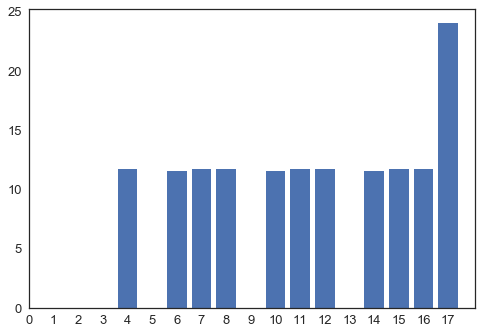

In [30]:
from policies import LiederPolicy
cost = 1.0
agent = Agent()
# pol = LiederPolicy(betas[cost][1:])
pol = LiederPolicy(betas[cost])
print(pol.theta)
agent.register(pol)
agent.register(make_env(cost))

def num_obs(s):
    return sum(int(not hasattr(x, 'sample')) for x in s)

sa = list(zip(*state_actions[cost].values()))
states = sorted(set(s for s, a in sa), key=num_obs)
s = states[902]
print(s)
p = pol.allQ(s)
plt.bar(range(len(p)), p)
plt.xticks(range(len(p)))
None

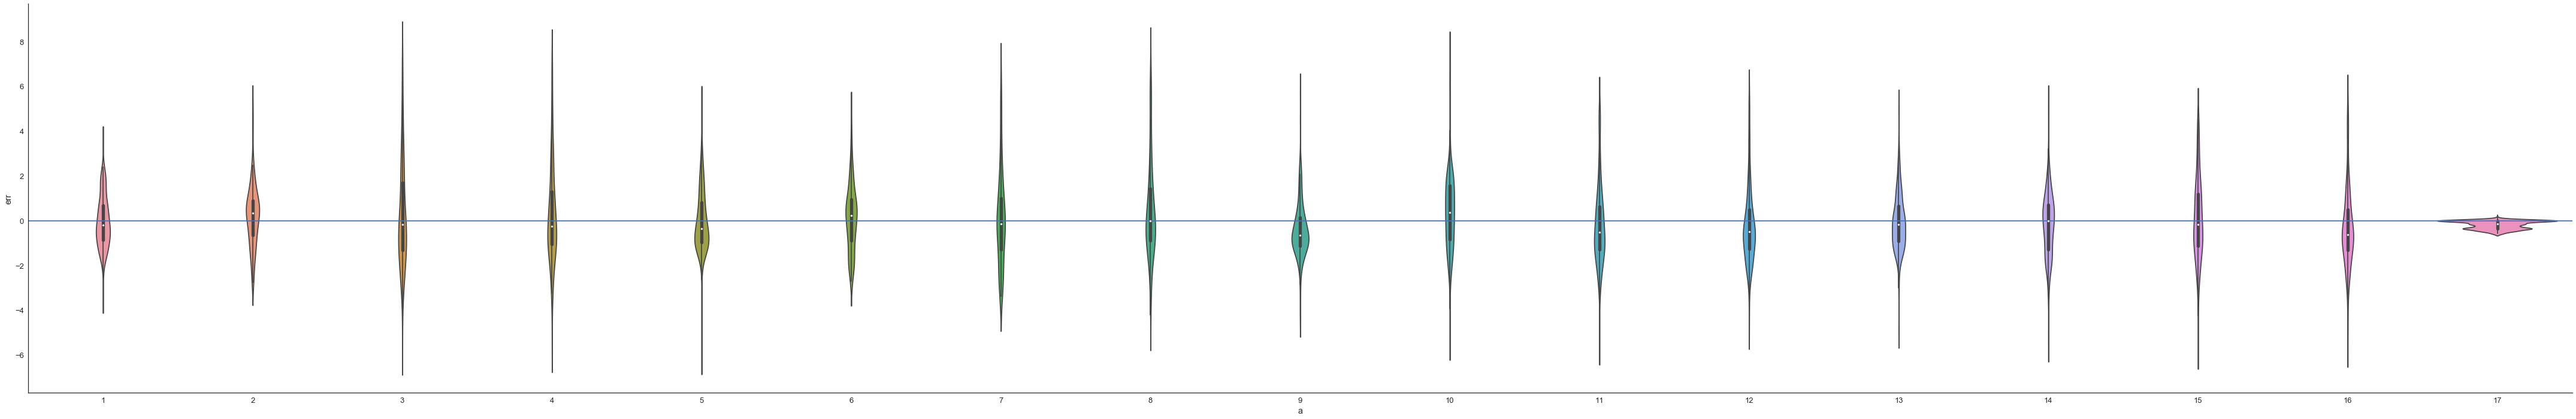

In [53]:
beta = np.linalg.inv(X.T @ X) @ X.T @ y
yhat = X @ beta
rms = np.sqrt(np.mean((yhat - y) ** 2))
df = pd.DataFrame(
    {'q': y,
     'a': np.array(state_actions[cost]['actions']),
     'err': yhat - y,
     'qhat': yhat
})
sns.factorplot('a', 'err', data=df, kind='violin', size=10, aspect=6)
plt.axhline(0)
# sns.distplot(df.query('a == 17').q)

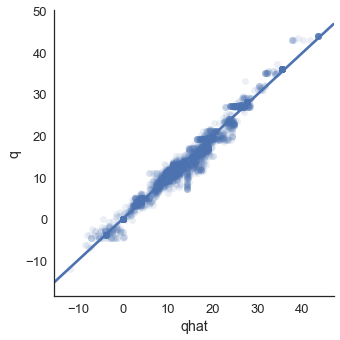

In [58]:
sns.lmplot('qhat', 'q', data=df, scatter_kws=dict(alpha=0.1))

In [518]:
df.query('a == 17').q
q = np.array(qs[cost])
# X[df.a == 17, -1].round(3)
# q[df.a == 17].round(3)
pd.Series(yhat[df.a == 17].round(3)).value_counts()
# X[df.a == 17]

 0.163     161
 27.845     99
 12.027     79
 35.754     55
 4.118      55
 19.936     46
-3.791      20
 43.663     18
 23.891     12
 15.982      5
 8.073       3
 31.800      2
-11.700      1
dtype: int64

In [224]:
import pymc3 as pm
import theano.tensor as tt

def regress(cost):
    X = np.stack(get_features(cost))
    y = np.array(qs[cost])
    
    with pm.Model() as model:
        beta = tt.concatenate([
#             pm.Exponential('intercept', 1, shape=(1,), testval=1e-10),
#             pm.Exponential('cost', 1, shape=(1,), testval=1.),
#             pm.Exponential('VOI', 3, shape=(3,), testval=1/3),
            tt.zeros(1),
            pm.Uniform('cost', 1, 16, shape=(1,)),
            pm.Beta('VOI', 1, 1, shape=(3,)),
            tt.ones(1)
        ])
#         sigma = pm.HalfCauchy('sigma', beta=10, testval=1.)
        sigma = pm.Exponential('sigma', 100
        likelihood = pm.Normal('likelihood', mu=tt.dot(X, beta), sd=sigma,
                               observed=y)
        
#         trace = pm.sample(500, njobs=20, progressbar=False, tune=1000)
        trace = None
        MAP = pm.find_MAP()
    return model, trace, MAP
        

model, trace, MAP = regress(1.00)
pprint(MAP)



  0%|          | 0/5000 [00:00<?, ?it/s]

logp = -7,506.5, ||grad|| = 34.802: 100%|██████████| 53/53 [00:00<00:00, 2310.55it/s]

{'VOI': array([  3.694e-08,   2.422e-07,   5.172e-01]),
 'VOI_logodds__': array([-17.114, -15.234,   0.069]),
 'cost': array([ 1.]),
 'cost_interval__': array([-15.352]),
 'sigma': array(1.9136456349219368),
 'sigma_log__': array(0.6490101321706021)}


In [220]:
from pprint import pprint
pprint(MAP)
# pm.traceplot(trace)


{'VOI_1': array([  2.592e-12]),
 'VOI_1_logodds__': array([-26.679]),
 'VOI_a': array([  1.228e-09]),
 'VOI_a_logodds__': array([-20.518]),
 'VOI_full': array([ 0.765]),
 'VOI_full_logodds__': array([ 1.179]),
 'cost': array([ 1.]),
 'cost_interval__': array([-15.155]),
 'sigma': array(3.1192498095758183),
 'sigma_log__': array(1.1375925272609253)}


In [ ]:

%%time
def test_pols(test_envs, policies):
    def test():
        # print('test', cost)
        for name, policy in policies.items():
            df = evaluate(policy, envs=test_envs)
            df['agent'] = name
            # df['depth'] = depth
            # df['cost'] = cost
            yield df
    df = pd.concat(test())
    print('done', depth, cost)
    return df

# with Parallel(n_jobs=48) as parallel:
#     data = parallel(delayed(run_params)(depth, cost)
#                     for cost, depth in bo_policies.keys()
# #                     for depth in range(2, 6)
# #                     for cost in np.logspace(-3, 0, 12)
#                    )
# #     df = pd.concat(data)
df = run_params(4, .05)












